# Example 7 from: [Markov conditions and factorization in logical credal networks](https://doi.org/10.1016/j.ijar.2024.109237)

In [1]:
# Imports

from dowhy import CausalModel
import sys
sys.path.append('../')
from parser_uai import UAIParser

## First Variation

![First_Variation](./figures/image.png)

### Modeling and Data

In [2]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data


,X1,X2,U1,U2,U3
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,1,1,1,1,0
996,1,1,1,1,0
997,1,1,1,1,0
998,1,1,1,1,0


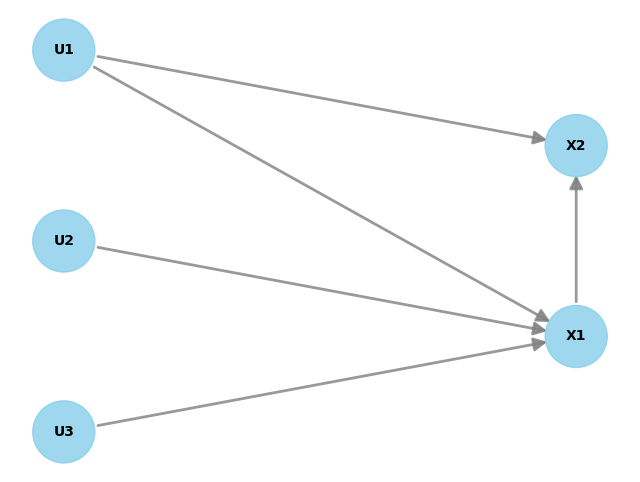

In [3]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [4]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations / Refutations

#### Propensity score stratification

In [5]:
estimate_stratification = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_stratification")

print(estimate_stratification)

ValueError: Not enough data to generate at least two strata. This error may be due to a high value of 'clipping_threshold'.

In [7]:
# Placebo Treatment Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_stratification,
    method_name="placebo_treatment_refuter",
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:0.008013134728631745
New effect:-0.011581358772433962
p value:0.8



#### Propensity score matching

In [6]:
identified_estimand_matching = identified_estimand
estimate_matching = model.estimate_effect(
    identified_estimand_matching, 
    method_name="backdoor.propensity_score_matching")

print(estimate_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: 0.5



In [7]:
ref = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.06751905089849845
p value:0.96



#### Propensity Score Weighting

In [8]:
identified_estimand_weighting = identified_estimand
estimate_weighting = model.estimate_effect(
    identified_estimand_weighting, 
    method_name="backdoor.propensity_score_weighting")

print(estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: 0.5152805073833049



In [9]:
ref = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="random_common_cause"
)

print(ref)

Refute: Add a random common cause
Estimated effect:0.5152805073833049
New effect:0.5152805073833048
p value:1.0



#### Instrumental Variable Estimation

In [12]:
identified_estimand_iv = identified_estimand
estimate_iv = model.estimate_effect(
    identified_estimand_iv, 
    method_name="iv.instrumental_variable")

print(estimate_iv)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₂  U₃]     ⎝d[U₂  U₃]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U2,U3})
Estimand assumption 2, Exclusion: If we remove {U2,U3}→{X1}, then ¬({U2,U3}→X2)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡  d       ⎤
E⎢──────(X₂)⎥
 ⎣dU2,U3    ⎦
─────────────
 ⎡  d       ⎤
E⎢──────(X₁)⎥
 ⎣dU2,U3    ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U2,U3})
Estimand assumption 2, Exclusion: If we remove {U2,U3}→{X1}, then ¬({U2,U3}→X2)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['X1'] is affected in the same way by common causes of ['X1'] and ['X2']
Estimand assumption 4, outcome_

In [13]:
ref = model.refute_estimate(
    identified_estimand,
    estimate_iv,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:4.402076577560186
New effect:4.432132805660258
p value:0.0



## Second Variation

![Second_Variation](./figures/image-1.png)

### Modeling and Data

In [14]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn2.uai")
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data.columns = ["X1", "X2", "U1", "U2"]
data.head()

,X1,X2,U1,U2
0,1,1,0,1
1,0,1,0,0
2,1,1,0,1
3,1,1,0,0
4,1,1,0,0


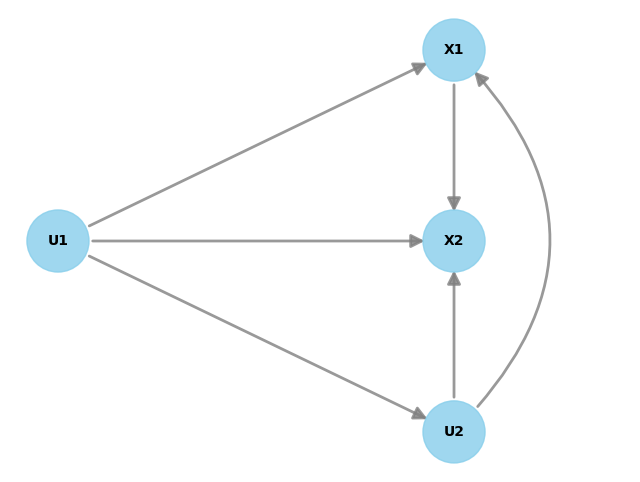

In [15]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.set_nodes(["X1", "X2", "U1", "U2"])
)

model.view_model()

### Identifying

In [16]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations / Refutations

#### Propensity score stratification

In [17]:
estimate_stratification = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_stratification")

print(estimate_stratification)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: -0.020480059093859276



In [18]:
# Placebo Treatment Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_stratification,
    method_name="placebo_treatment_refuter"
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.020480059093859276
New effect:0.0011948064132950764
p value:0.8999999999999999



#### Propensity score matching

In [19]:
estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print(estimate_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: 0.002



In [20]:
# Dummy Outcome Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.020613760052734287
p value:0.98



#### Propensity score weighting

In [21]:
# Propensity Score Weighting
estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print(estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: -0.020095280113678116



In [22]:
# Random Common Cause Refuter - Weighting

ref = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="random_common_cause"
)

print(ref)

Refute: Add a random common cause
Estimated effect:-0.020095280113678116
New effect:-0.020095280113678112
p value:1.0



## Third Variation

![Third_Variantion](figures/image-3.png)

### Modeling and Data

In [23]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn3.uai")
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data.columns = ["X1", "X2", "U1"]
data.head()

,X1,X2,U1
0,0,1,1
1,1,0,0
2,0,0,0
3,0,1,2
4,0,1,0


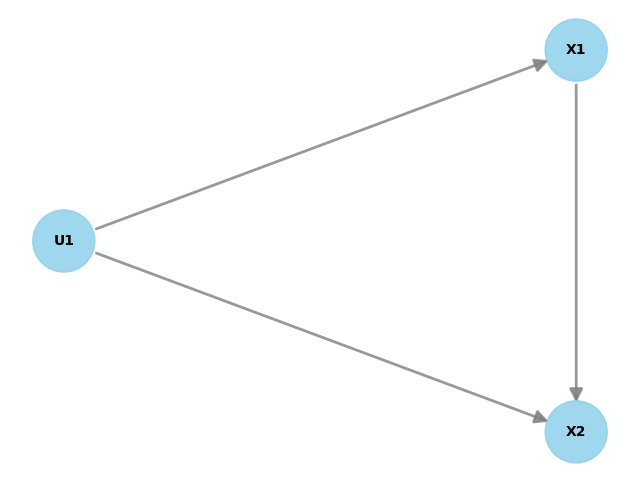

In [24]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.set_nodes(["X1", "X2", "U1", "U2", "U3"])
)

model.view_model()

### Identifying

In [25]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations / Refutations

#### Propensity score stratification

In [26]:
estimate_stratification = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_stratification")

print(estimate_stratification)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.010204907656406024



In [27]:
# Placebo Treatment Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_stratification,
    method_name="placebo_treatment_refuter"
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.010204907656406024
New effect:0.0024053727131342333
p value:0.8400000000000001



#### Propensity score matching

In [28]:
estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print(estimate_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.04000000000000001



In [29]:
# Dummy Outcome Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.01393470112195305
p value:0.96



#### Propensity score weighting

In [30]:
# Propensity Score Weighting
estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print(estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.010656034541316917



In [31]:
# Random Common Cause Refuter - Weighting

ref = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="random_common_cause"
)

print(ref)

Refute: Add a random common cause
Estimated effect:-0.010656034541316917
New effect:-0.010656034541316917
p value:1.0



## Some Conclusions

In all variations, the `PropensityScoreMatching` method generated different $ATE$ values, when compared with both of the other `PropensityScore...` ones. 

Besides, in the [First Variation](#first-variation), we utilized the `InstrumentalVariableEstimator` method. However, we observed that the estimated value was significantly beyond the acceptable range (between -1 and 1), especially considering that the outcome is a binary variable.
